In [1]:
import numpy as np
import pennylane as qml
import pennylane.numpy as qnp
import scipy.stats as ss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.covariance import EmpiricalCovariance
import pickle 
def load_iris(src: str):
    data = np.loadtxt(src)
    dims = data.shape[1]
    X = data[:, 0:dims-1]
    y = data[:, -1]
    print(f"Num samples in Iris: {len(X)}")
    return X, y

def load_wine(src: str):
    data = np.load(src)
    dims = data.shape[1]
    X = data[:, 0:dims-1]
    y = data[:, -1]
    print(f"Num samples in Wine: {len(X)}")
    return X, y



save = lambda obj, f: pickle.dump(obj, open(f, 'wb'))
load = lambda f: pickle.load(open(f, 'rb'))

In [2]:
def qckt(params, data):
    """ Pennylane circuit 2: This circuit uses
    classical data and internally angle embeds the data. The params
    are initialized as before.
    
    LIMITATION: The number of qubits(n) must be equal to or greater than
    the number of dimensions of the data(N). (N <= n)
    """
    assert len(params.shape) == 3, f"Expected param shape len: 3, got {len(params.shape)}"
    nqubits = params.shape[1]
    qml.AngleEmbedding(data, wires=range(nqubits), rotation="X")
    for param in params:
        layer(param)
    
    return qml.expval(qml.PauliZ(0))


def layer(params):
    # params: [nqubits x rot-params]
    # nqubits = nfeatures
    nfeats = params.shape[0]
    for i in range(nfeats):
        qml.Rot(params[i, 0], params[i,1], params[i, 2], wires=i)
    
    for i in range(nfeats - 1):
        qml.CNOT(wires=[i, i+1])


def mse_loss(label, pred):
    loss = 0
    for l, p in zip(label, pred):
        loss = loss + (l - p) ** 2

    loss = loss / len(label)
    return loss

def accuracy(label, preds):
    corr = 0
    for l,p in zip(label, preds):
        if abs(l-p) < 1e-5:
            corr += 1
    acc = corr / len(label)
    return acc

def get_preds(ckt, params, data):
    preds = [qnp.sign(ckt(params, d)) for d in data]
    return preds

def cost(params, data, label):
    val = [ckt(params, d) for d in data]
    return mse_loss(label, val)

In [3]:
def init_uniform_norm(data, shape):
    dr = data.reshape(data.size)
    sz = np.prod(shape)
    dmin, dmax = np.min(data), np.max(data)
    for i in range(len(data)):
        dr[i] = (dr[i] - dmin)/(dmax - dmin)
    zmask = dr <= 0
    omask = dr >= 1
    dr[zmask] = dr[zmask] + 1e-8
    dr[omask] = dr[omask] - 1e-8
    l, h = ss.uniform.fit(dr)
    print(f"Determined range: [{l},{h}]")
    return qnp.random.uniform(l, h, size=sz).reshape(shape)

def init_beta_ebayes(data, shape):
    data_r = data.reshape(data.size)
    sz = np.prod(shape)
    dmin, dmax = np.min(data_r), np.max(data_r)
    for i in range(len(data_r)):
        data_r[i] = (data_r[i] - dmin) / (dmax - dmin)
    zmask = data_r <= 0
    omask = data_r >= 1
    data_r[zmask] = data_r[zmask] + 1e-8
    data_r[omask] = data_r[omask] - 1e-8 
    a, b, _, _ = ss.beta.fit(data_r, floc=0, fscale=1)
    print(f"Found alpha:{a}, beta:{b}")
    return qnp.random.beta(a=a, b=b, size=sz).reshape(shape)


In [4]:
X, y = load_iris('data/iris_classes1and2_scaled.txt')
# init_uniform_norm(X, (2, 4, 3)).shape

Num samples in Iris: 100


In [5]:
qubits = [4, 5, 6, 7, 8, 9, 10]
# qubits = [7]
devs = [qml.device('default.qubit', wires=qub) for qub in qubits]
ckts = [qml.QNode(qckt, dev) for dev in devs]

In [6]:
def softmax(x):
    z = x - np.max(x)
    num = np.exp(z)
    denom = np.sum(num)
    return num/denom

_ckt = ckts[0]
params = qnp.random.uniform(0, 1, size=24).reshape(2, 4, 3)
gfn = qml.grad(_ckt, argnum=0)
grad = qnp.array([gfn(params, d) for d in X])
# grad.shape
# pnew = params + gn
# # pnew.shape
# np.mean(gn, axis=0).shape

NameError: name 'gn' is not defined

In [8]:
gt = 1.0
for i in range(10):
    gn = 0.9 * gt -  softmax(grad /np.linalg.norm(grad, 1, axis=0))
    print(f"Previous {np.mean(gt)}, Next {np.mean(gn)}")
    gt = gn

Previous 1.0, Next 0.8995833333333333
Previous 0.8995833333333333, Next 0.8092083333333333
Previous 0.8092083333333333, Next 0.7278708333333334
Previous 0.7278708333333334, Next 0.6546670833333333
Previous 0.6546670833333333, Next 0.5887837083333334
Previous 0.5887837083333334, Next 0.5294886708333334
Previous 0.5294886708333334, Next 0.47612313708333337
Previous 0.47612313708333337, Next 0.42809415670833345
Previous 0.42809415670833345, Next 0.3848680743708334
Previous 0.3848680743708334, Next 0.3459646002670834


## Training rules

In [6]:
def train_ckt(ckt, init_fn, cfg, iters=50, eta=1.0, perturb=False):
    qubits = len(ckt.device.wires)
    pinit = init_fn(cfg['X'], (cfg['layers'], qubits, 3))
    params = pinit
    opt = cfg['opt'](cfg['lr'])
    data, label = cfg['X'], cfg['y']
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8)
    grad = qml.grad(ckt, argnum=0)
    grad_var = []
    
    gvals = []
    costs = []
    gt = np.ones_like(params)
    gt = np.repeat(gt, len(X_tr), axis=0).reshape(len(X_tr), *params.shape)
    # print(params.shape)
    for i in range(iters):
        params, _, _, = opt.step(cost, params, X_tr, y_tr)
        grad_vals = qnp.array([grad(params, d) for d in X_tr])
        gvals.append(grad_vals)
        gvar = np.var(grad_vals)
        gvals.append(grad_vals)
        if perturb:
            # eps = np.random.uniform(0, 0.5)
            # gn = 0.9 * gt - softmax(grad_vals / np.linalg.norm(grad_vals, 2, axis=0))
            sc = eta/((1+i)**(0.55+gvar))
            # params = params + eps * np.mean(gn, axis=0)
            # gt = gn
            params = params + qnp.random.normal(loc=0.0, scale=sc, size=(cfg['layers']*qubits*3)).reshape(cfg['layers'],qubits, 3)
        if i != 0 and i % 5 == 0:
            gv = np.var(np.array(gvals)[:, -1])
            grad_var.append(gv)
            gvals = []
        # print(params.shape)
        tcost = cost(params, X_tr, y_tr)
        costs.append(tcost)
        tr_preds = get_preds(ckt, params, X_tr)
        te_preds = get_preds(ckt, params, X_te)
        tr_acc = accuracy(y_tr, tr_preds)
        te_acc = accuracy(y_te, te_preds)
        
        print(f"{i}| Cost: {tcost:.2f} | Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    return grad_var, costs

In [ ]:
def train_ckt_new(ckt, cfg, iters=50):
    '''using be-init algorithm'''
    qubits = len(ckt.device.wires)
    pinit, a, b = init_beta_ebayes(cfg['X'], (cfg['layers'], qubits, 3))
    params = pinit
    print(params.shape)
    opt = cfg['opt'](cfg['lr'])
    data, label = cfg['X'], cfg['y']
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, train_size=0.8)
    grad = qml.grad(ckt, argnum=0)
    grad_var = []
    gvals = []
    eta = 0.3
    # ecv = EmpiricalCovariance()
    # gp = qnp.array([grad(parms, d) for d in X_tr])
    # gp += normal(noise)
    for i in range(iters):
        params, _, _ = opt.step(cost, params, X_tr, y_tr)
        grad_vals = qnp.array([grad(params, d) for d in X_tr])
        gvar = np.var(grad_vals)
        gvals.append(grad_vals)
        gmatrix = grad_vals.reshape(grad_vals.shape[0], -1)
        # covar = ecv.fit(gmatrix) 
        # tr_var = np.trace(covar.covariance_)
        sc = eta/((1+i)**(0.55+gvar))
        # sc = tr_var
        params = params + qnp.random.normal(loc=0.0, scale=sc, size=(cfg['layers']*qubits*3)).reshape(cfg['layers'],qubits, 3)
        if i != 0 and i % 5 == 0:
            gv = np.var(np.array(gvals)[:, -1])
            grad_var.append(gv)
            gvals = []
        
        
        # if i != 0 and i % 5 == 0:
        #     # gvals = [nacc x |X_tr| x layers x qubits x 3]
        #     gvarr = np.array(gvals)
        #     # print(np.array(gvals).shape)
        #     gmean = np.mean(gvarr)
        #     gvar = np.var(gvarr)
        #     glst = np.var(gvarr[:, -1, :, : ,:])
        #     grad_var.append(glst)
        #     alpha = gmean*gvar / (gmean - (gmean**2 + gvar))
        #     beta = gvar* ( 1 - gmean) / (gmean - (gmean**2 + gvar))
        #     a_p, b_p = a, b
        #     a_n =  alpha
        #     b_n =  beta
        #     a = a_n if a_n > 0 else a_p
        #     b = a_n if b_n > 0 else b_p
        #     scale = gvar / (1 + i) * cfg['lr']
        #     params = params + qnp.random.normal(loc=0.0, scale=scale, size=(cfg['layers']*qubits*3)).reshape(cfg['layers'], qubits, 3)
        #     # params = 0.5 * params + 0.5 * qnp.random.beta(a,b, size=(cfg['layers']*qubits*3)).reshape(cfg['layers'], qubits, 3)
        #     gvals = []
        tcost = cost(params, X_tr, y_tr)
        tr_preds = get_preds(ckt, params, X_tr)
        te_preds = get_preds(ckt, params, X_te)
        tr_acc = accuracy(y_tr, tr_preds)
        te_acc = accuracy(y_te, te_preds)
        
        print(f"{i}| Cost: {tcost:.2f} | Train Acc: {tr_acc:.4f} | Test Acc: {te_acc:.4f}")
    return grad_var
            


In [7]:
cfg = {
    'X': X,
    'y': y,
    'opt': qml.NesterovMomentumOptimizer,
    'lr': 0.1,
    'layers': 2
}

In [74]:
# grad_vars = {}
grad_vars_beta = {}
for ckt in ckts:
    _qub = len(ckt.device.wires) 
    print(f"Training with {_qub} qubits")
    gvars = train_ckt(ckt, init_beta_ebayes, cfg)
    grad_vars_beta[_qub] = gvars

Training with 4 qubits
Found alpha:0.6012422455108549, beta:1.3769123810922432


/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(
/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


AssertionError: Expected param shape len: 3, got 1

In [8]:
grad_vars_unif = {}
cost_unif = {}
for ckt in ckts:
    _qub = len(ckt.device.wires)
    print(f"Training with {_qub} qubits for uniform no perturbation")
    gvarsu, costsu = train_ckt(ckt, init_uniform_norm, cfg)
    grad_vars_unif[_qub] = gvarsu
    cost_unif[_qub] = costsu

# save(grad_vars_unif, 'uniform_iris_qubit_7.pkl')

Training with 4 qubits for uniform no perturbation
Determined range: [1e-08,2.04999998]


/lustre/acslab/users/2305/software/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.97 | Train Acc: 0.4375 | Test Acc: 0.7500
1| Cost: 1.81 | Train Acc: 0.4125 | Test Acc: 0.7500
2| Cost: 1.54 | Train Acc: 0.3375 | Test Acc: 0.7500
3| Cost: 1.26 | Train Acc: 0.2875 | Test Acc: 0.5000
4| Cost: 1.10 | Train Acc: 0.5375 | Test Acc: 0.2500
5| Cost: 1.01 | Train Acc: 0.5625 | Test Acc: 0.2500
6| Cost: 0.94 | Train Acc: 0.5625 | Test Acc: 0.2500
7| Cost: 0.84 | Train Acc: 0.5625 | Test Acc: 0.2500
8| Cost: 0.76 | Train Acc: 0.5625 | Test Acc: 0.2500
9| Cost: 0.71 | Train Acc: 0.7125 | Test Acc: 0.3500
10| Cost: 0.70 | Train Acc: 0.8875 | Test Acc: 0.7500
11| Cost: 0.72 | Train Acc: 0.9750 | Test Acc: 1.0000
12| Cost: 0.73 | Train Acc: 0.9375 | Test Acc: 0.9500
13| Cost: 0.72 | Train Acc: 0.9375 | Test Acc: 0.9500
14| Cost: 0.68 | Train Acc: 0.9500 | Test Acc: 0.9000
15| Cost: 0.64 | Train Acc: 0.9625 | Test Acc: 0.8500
16| Cost: 0.62 | Train Acc: 0.8875 | Test Acc: 0.7000
17| Cost: 0.60 | Train Acc: 0.8375 | Test Acc: 0.6000
18| Cost: 0.59 | Train Acc: 0.8000 | T

In [9]:
grad_vars_beinit = {}
cost_beinit = {}
for ckt in ckts:
    _qub = len(ckt.device.wires) 
    print(f"Training with {_qub} qubits with beinit")
    gvars_be, costs_beinit = train_ckt(ckt, init_beta_ebayes, cfg, perturb=True)
    grad_vars_beinit[_qub] = gvars_be
    cost_beinit[_qub] = costs_beinit

# save(grad_vars_beinit, 'beinit_iris_qubit_7.pkl')

Training with 4 qubits with beinit
Found alpha:0.6012422455108549, beta:1.3769123810922432
0| Cost: 1.70 | Train Acc: 0.4625 | Test Acc: 0.5000
1| Cost: 1.72 | Train Acc: 0.4000 | Test Acc: 0.5000
2| Cost: 1.52 | Train Acc: 0.1625 | Test Acc: 0.2500
3| Cost: 1.38 | Train Acc: 0.1500 | Test Acc: 0.2000
4| Cost: 1.27 | Train Acc: 0.4250 | Test Acc: 0.5000
5| Cost: 1.29 | Train Acc: 0.1250 | Test Acc: 0.2000
6| Cost: 1.28 | Train Acc: 0.5000 | Test Acc: 0.5000
7| Cost: 1.52 | Train Acc: 0.5000 | Test Acc: 0.5000
8| Cost: 1.68 | Train Acc: 0.5000 | Test Acc: 0.5000
9| Cost: 1.13 | Train Acc: 0.5000 | Test Acc: 0.5000
10| Cost: 1.04 | Train Acc: 0.5000 | Test Acc: 0.5000
11| Cost: 0.92 | Train Acc: 0.5750 | Test Acc: 0.5000
12| Cost: 0.66 | Train Acc: 0.9000 | Test Acc: 0.9000
13| Cost: 0.83 | Train Acc: 0.5500 | Test Acc: 0.5500
14| Cost: 0.84 | Train Acc: 0.6000 | Test Acc: 0.5500
15| Cost: 0.91 | Train Acc: 0.5000 | Test Acc: 0.5000
16| Cost: 0.97 | Train Acc: 0.5625 | Test Acc: 0.6500
1

In [29]:
grad_vars_unif_pert = {}
cost_unifp = {}
for ckt in ckts:
    _qub = len(ckt.device.wires)
    print(f"Training with {_qub} qubits for uniform and perturbation")
    gvarsup, cup = train_ckt(ckt, init_uniform_norm, cfg, perturb=True)
    grad_vars_unif_pert[_qub] = gvarsup
    cost_unifp[_qub] = cup

# save(grad_vars_unif_pert, 'unif_pert_iris_qubit_7.pkl')

Training with 4 qubits for uniform and perturbation
Determined range: [1e-08,2.04999998]


/lustre/acslab/users/2305/software/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.13 | Train Acc: 0.3875 | Test Acc: 0.2500
1| Cost: 1.43 | Train Acc: 0.5125 | Test Acc: 0.4500
2| Cost: 1.53 | Train Acc: 0.4875 | Test Acc: 0.5500
3| Cost: 1.53 | Train Acc: 0.5125 | Test Acc: 0.4500
4| Cost: 1.40 | Train Acc: 0.5125 | Test Acc: 0.4500
5| Cost: 1.49 | Train Acc: 0.5125 | Test Acc: 0.4500
6| Cost: 1.28 | Train Acc: 0.4750 | Test Acc: 0.3500
7| Cost: 0.89 | Train Acc: 0.5500 | Test Acc: 0.4500
8| Cost: 1.06 | Train Acc: 0.5125 | Test Acc: 0.4500
9| Cost: 1.17 | Train Acc: 0.5125 | Test Acc: 0.4500
10| Cost: 0.80 | Train Acc: 0.6750 | Test Acc: 0.4500
11| Cost: 0.73 | Train Acc: 0.9250 | Test Acc: 0.9000
12| Cost: 0.77 | Train Acc: 0.8375 | Test Acc: 0.6000
13| Cost: 0.72 | Train Acc: 0.8875 | Test Acc: 0.9000
14| Cost: 0.75 | Train Acc: 0.9250 | Test Acc: 0.9000
15| Cost: 0.86 | Train Acc: 0.5625 | Test Acc: 0.4500
16| Cost: 0.87 | Train Acc: 0.5875 | Test Acc: 0.4500
17| Cost: 0.73 | Train Acc: 0.6750 | Test Acc: 0.5000
18| Cost: 0.79 | Train Acc: 0.6750 | T

In [19]:
grad_vars_beinit_upert = {}
for ckt in ckts:
    _qub = len(ckt.device.wires) 
    print(f"Training with {_qub} qubits with beinit no perturbation")
    gvars_be = train_ckt(ckt, init_beta_ebayes, cfg, eta=0.3, perturb=False)
    grad_vars_beinit_upert[_qub] = gvars_be


Training with 4 qubits with beinit no perturbation
Found alpha:0.6012422455108549, beta:1.3769123810922432


/lustre/acslab/users/2305/software/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.82 | Train Acc: 0.5000 | Test Acc: 0.5000
1| Cost: 1.74 | Train Acc: 0.4875 | Test Acc: 0.4500
2| Cost: 1.62 | Train Acc: 0.4250 | Test Acc: 0.4000
3| Cost: 1.49 | Train Acc: 0.3125 | Test Acc: 0.2500
4| Cost: 1.41 | Train Acc: 0.1375 | Test Acc: 0.1500
5| Cost: 1.36 | Train Acc: 0.2750 | Test Acc: 0.1500
6| Cost: 1.30 | Train Acc: 0.4500 | Test Acc: 0.4500
7| Cost: 1.20 | Train Acc: 0.4875 | Test Acc: 0.5000
8| Cost: 1.06 | Train Acc: 0.5000 | Test Acc: 0.5000
9| Cost: 0.92 | Train Acc: 0.5125 | Test Acc: 0.5000
10| Cost: 0.82 | Train Acc: 0.8625 | Test Acc: 0.8500
11| Cost: 0.75 | Train Acc: 0.9875 | Test Acc: 0.9500
12| Cost: 0.70 | Train Acc: 0.9875 | Test Acc: 0.9500
13| Cost: 0.67 | Train Acc: 0.9875 | Test Acc: 0.9000
14| Cost: 0.65 | Train Acc: 0.9750 | Test Acc: 0.9000
15| Cost: 0.64 | Train Acc: 0.9625 | Test Acc: 0.8500
16| Cost: 0.63 | Train Acc: 0.9375 | Test Acc: 0.8500
17| Cost: 0.63 | Train Acc: 0.9375 | Test Acc: 0.8500
18| Cost: 0.61 | Train Acc: 0.9375 | T

In [67]:
ckpts = ['src/ckpts/iris/iris_qubit_1.0_0.0_beta_ebayes.pkl', 
         'src/ckpts/iris/iris_qubit_0.5_0.5_beta_ebayes.pkl',
        'src/ckpts/iris/iris_qubit_0.5_1.0_beta_ebayes.pkl',
        'src/ckpts/iris/iris_qubit_0.7_0.5_beta_ebayes.pkl',
        'src/ckpts/iris/iris_qubit_0.7_0.7_beta_ebayes.pkl']

cdata = [pickle.load(open(c, 'rb')) for c in ckpts]
cvars = [c[-1] for c in cdata]

In [ ]:
def plot_costs(cost_dict, qubits,title, save=None):
    for q in qubits:
        plt.plot(cost_dict[q], label=f'{q}', alpha=0.7)
    plt.grid(True, lw=.3)
    plt.title(title)
    plt.legend(title='Qubits')
    plt.ylabel('Cost')
    plt.xlabel('Iteration')
    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

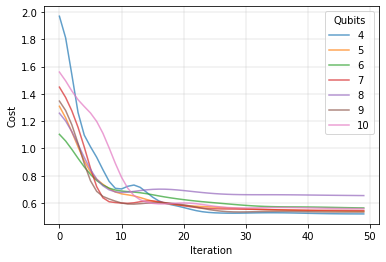

In [26]:
carr = np.array([cost_unif[q] for q in qubits])
cmean = np.mean(carr, axis=-1)
cstd = np.std(carr, axis=-1)

for i, q in enumerate(qubits):
    plt.plot(cost_unif[q], label=f'{q}', alpha=0.7)
    # plt.fill_between(cost_unif[q], _cm - _cs, _cm + _cs, alpha=0.3)
plt.grid(True, lw=.3)
plt.legend(title='Qubits')
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.show()

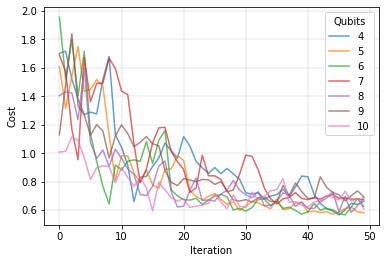

In [27]:
for q in qubits:
    plt.plot(cost_beinit[q], label=f'{q}', alpha=0.7)
plt.grid(True, lw=.3)
plt.legend(title='Qubits')
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.show()

TypeError: float() argument must be a string or a number, not 'dict'

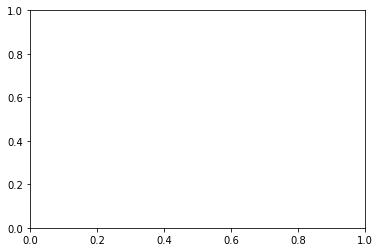

In [28]:
for q in qubits:
    plt.plot(cost_unifp[q], label=f'{q}', alpha=0.7)
plt.grid(True, lw=.3)
plt.legend(title='Qubits')
plt.ylabel('Cost')
plt.xlabel('Iteration')
plt.show()

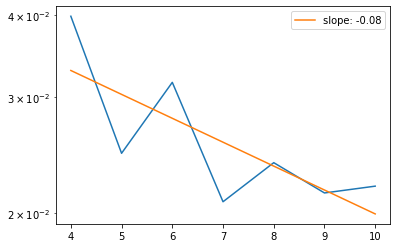

In [13]:
# gv_avg_beta = [grad_vars_beta[k][-1] for k in grad_vars_beta]
gv_avg_unif = [grad_vars_unif[k][-1] for k in grad_vars_unif]

p1 = np.polyfit(qubits, np.log(gv_avg_unif), 1)
plt.semilogy(qubits, gv_avg_unif)
plt.semilogy(qubits, np.exp(p1[0]*np.array(qubits, dtype='float') + p1[1]), label=f"slope: {p1[0]:3.2f}")
# p = np.polyfit(qubits, np.log(gv_avg_beta), 1)
plt.legend()

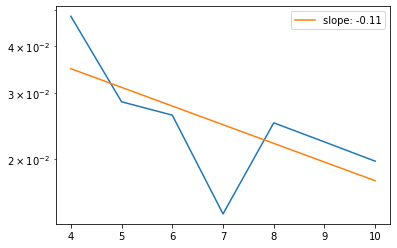

In [15]:
gv_avg_beinit = [grad_vars_beinit[k][-1] for k in grad_vars_beinit]
pb = np.polyfit(qubits, np.log(gv_avg_beinit), 1)

plt.semilogy(qubits, gv_avg_beinit)
plt.semilogy(qubits, np.exp(pb[0]*np.array(qubits, dtype='float') + pb[1]), label=f"slope: {pb[0]:3.2f}")
plt.legend()

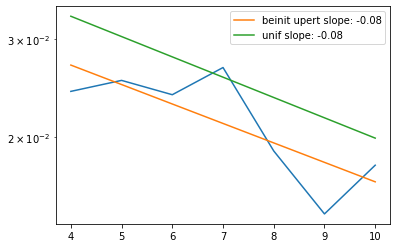

In [16]:
gv_avg_beinit_up = [grad_vars_beinit_upert[k][-1] for k in grad_vars_beinit_upert]
pbu = np.polyfit(qubits, np.log(gv_avg_beinit_up), 1)

plt.semilogy(qubits, gv_avg_beinit_up)
plt.semilogy(qubits, np.exp(pbu[0]*np.array(qubits, dtype='float') + pbu[1]), label=f"beinit upert slope: {pbu[0]:3.2f}")
plt.semilogy(qubits, np.exp(p1[0]*np.array(qubits, dtype='float') + p1[1]), label=f"unif slope: {p1[0]:3.2f}")
plt.legend()

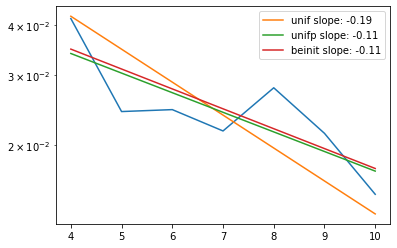

In [16]:
gv_unif_pert_avg = [grad_vars_unif_pert[k][-1] for k in grad_vars_unif_pert]
pu = np.polyfit(qubits, np.log(gv_unif_pert_avg), 1)
plt.semilogy(qubits, gv_unif_pert_avg)
# plt.semilogy(qubits, gv_avg_unif)
plt.semilogy(qubits, np.exp(p1[0]*np.array(qubits, dtype='float') + p1[1]), label=f"unif slope: {p1[0]:3.2f}")
plt.semilogy(qubits, np.exp(pu[0]*np.array(qubits, dtype='float') + pu[1]), label=f"unifp slope: {pu[0]:3.2f}")
plt.semilogy(qubits, np.exp(pb[0]*np.array(qubits, dtype='float') + pb[1]), label=f"beinit slope: {pb[0]:3.2f}")
plt.legend()

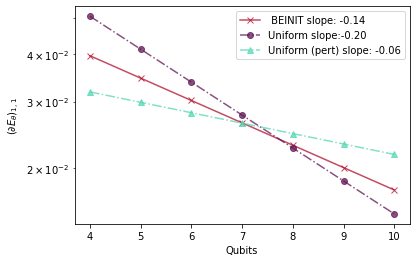

In [17]:
# plt.semilogy(qubits, gv_avg_beinit, label='beta')
plt.semilogy(qubits, np.exp(pb[0]*np.array(qubits, dtype='float') + pb[1]), '-x',
             c='#b00f2b', alpha=0.75,
             label=f" BEINIT slope: {pb[0]:3.2f}")
# plt.semilogy(qubits, gv_avg_unif, 'o', label='uniform')
plt.semilogy(qubits, np.exp(p1[0]*np.array(qubits, dtype='float') + p1[1]),'o-.',
             c='#611754', alpha=0.75,
             label=f"Uniform slope:{p1[0]:3.2f}")
# plt.semilogy(qubits, gv_unif_pert_avg)
plt.semilogy(qubits, np.exp(pu[0]*np.array(qubits, dtype='float') + pu[1]), '^-.',
             c='#55d8b4', alpha=0.75, 
             label=f"Uniform (pert) slope: {pu[0]:3.2f}")
plt.legend()
plt.xlabel("Qubits")
plt.ylabel(r"($\partial E_{\theta})_{1, 1}$")
# plt.savefig("iris_beinit_experiments.png", dpi=300, bbox_inches='tight')
plt.show()
# plt.semilogy(qubits[::-1], [np.mean(cvars[-1][k]) for k in cvars[-1]])

In [51]:
sckt = ckts[0]
gfun = qml.grad(sckt, argnum=0)
params, a, b = init_beta_ebayes(X, (2, 4, 3))

gradient = qnp.array([gfun(params, d) for d in X])
gradient.shape

Found alpha:0.6012422455108549, beta:1.3769123810922432


(100, 2, 4, 3)

In [68]:
gv = gradient.reshape(gradient.shape[0], -1)

ev = EmpiricalCovariance()
covar = ev.fit(gv)
covar.covariance_.shape

(24, 24)

In [12]:
with open('scaled_beinit.pkl', 'wb') as out:
    pickle.dump(grad_vars_beinit, out)

NameError: name 'grad_vars_beinit' is not defined

In [38]:
with open('uniform_iris.pkl', 'wb') as outf:
    pickle.dump(grad_vars_unif, outf)

In [37]:
with open('scale_beinit_0.3_v1.pkl', 'wb') as of1:
    pickle.dump(grad_vars_beinit, of1)

In [39]:
with open('scaled_uniform_pert.pkl', 'wb') as of2:
    pickle.dump(grad_vars_unif_pert, of2)

In [16]:
old_expt = pickle.load(open('scale_beinit_0.3.pkl', 'rb'))
oavg = [old_expt[k][-1] for k in old_expt]
ob = np.polyfit(qubits, np.log(oavg), 1)

In [18]:
unif = pickle.load(open('uniform_iris.pkl', 'rb'))
uavg = [unif[k][-1] for k in unif]
ub = np.polyfit(qubits, np.log(uavg), 1)

EOFError: Ran out of input

## Tests with Layers

In [7]:
layers = [2, 4, 6, 8, 10, 15, 20, 25, 30]
cfgs = []
for l in layers:
    _cfg = {'X': X,
    'y': y,
    'opt': qml.NesterovMomentumOptimizer,
    'lr': 0.1,'layers': l}
    cfgs.append(_cfg)

In [11]:
unif_pert_layer = {}
ckt = ckts[0]
for cfg in cfgs:
    print(f"Training with {cfg['layers']} layers")
    _lvar = train_ckt(ckt, init_fn=init_uniform_norm, cfg=cfg, perturb=True)
    unif_pert_layer[cfg['layers']]=_lvar
    
    
save(unif_pert_layer, 'iris_uniform_perturbed_layers.pkl')

Training with 2 layers
Determined range: [1e-08,2.04999998]


/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.03 | Train Acc: 0.3500 | Test Acc: 0.3000
1| Cost: 1.06 | Train Acc: 0.4750 | Test Acc: 0.3500
2| Cost: 0.88 | Train Acc: 0.5875 | Test Acc: 0.4000
3| Cost: 0.89 | Train Acc: 0.6875 | Test Acc: 0.6000
4| Cost: 0.98 | Train Acc: 0.5750 | Test Acc: 0.5000
5| Cost: 1.22 | Train Acc: 0.4250 | Test Acc: 0.6000
6| Cost: 1.23 | Train Acc: 0.2625 | Test Acc: 0.3500
7| Cost: 1.04 | Train Acc: 0.3875 | Test Acc: 0.4000
8| Cost: 0.95 | Train Acc: 0.5250 | Test Acc: 0.4000
9| Cost: 0.85 | Train Acc: 0.5250 | Test Acc: 0.4000
10| Cost: 0.91 | Train Acc: 0.5250 | Test Acc: 0.4000
11| Cost: 0.83 | Train Acc: 0.5500 | Test Acc: 0.4000
12| Cost: 0.91 | Train Acc: 0.5250 | Test Acc: 0.4000
13| Cost: 0.82 | Train Acc: 0.5250 | Test Acc: 0.4500
14| Cost: 0.63 | Train Acc: 0.8500 | Test Acc: 0.9000
15| Cost: 0.63 | Train Acc: 0.9125 | Test Acc: 0.8500
16| Cost: 0.64 | Train Acc: 0.8250 | Test Acc: 0.8000
17| Cost: 0.65 | Train Acc: 0.8625 | Test Acc: 0.8000
18| Cost: 0.73 | Train Acc: 0.6750 | T

In [26]:
beinit_pert_layer = {}
ckt = ckts[0]
for cfg in cfgs:
    print(f"Training with {cfg['layers']} layers")
    _blvar = train_ckt_new(ckt, cfg=cfg)
    beinit_pert_layer[cfg['layers']]=_blvar
    
save(beinit_pert_layer, 'iris_beinit_layers.pkl')

Training with 2 layers
Found alpha:0.6012422455108549, beta:1.3769123810922432
(2, 4, 3)
0| Cost: 0.90 | Train Acc: 0.4750 | Test Acc: 0.6000
1| Cost: 1.19 | Train Acc: 0.4250 | Test Acc: 0.4000
2| Cost: 1.29 | Train Acc: 0.5250 | Test Acc: 0.4000
3| Cost: 1.55 | Train Acc: 0.4750 | Test Acc: 0.3500
4| Cost: 1.43 | Train Acc: 0.5250 | Test Acc: 0.3500
5| Cost: 1.31 | Train Acc: 0.4875 | Test Acc: 0.3500
6| Cost: 1.30 | Train Acc: 0.2250 | Test Acc: 0.3500
7| Cost: 1.12 | Train Acc: 0.3000 | Test Acc: 0.4500
8| Cost: 1.03 | Train Acc: 0.5250 | Test Acc: 0.4000
9| Cost: 1.10 | Train Acc: 0.5250 | Test Acc: 0.4000
10| Cost: 0.95 | Train Acc: 0.6875 | Test Acc: 0.6500
11| Cost: 0.89 | Train Acc: 0.6500 | Test Acc: 0.7000
12| Cost: 0.81 | Train Acc: 0.6750 | Test Acc: 0.5000
13| Cost: 0.70 | Train Acc: 0.8750 | Test Acc: 0.8000
14| Cost: 0.73 | Train Acc: 0.7500 | Test Acc: 0.7000
15| Cost: 0.70 | Train Acc: 0.7750 | Test Acc: 0.7000
16| Cost: 0.69 | Train Acc: 0.7500 | Test Acc: 0.6500
17|

In [22]:
unif_baseline = {}
ckt = ckts[0]
for cfg in cfgs:
    print(f"Training with {cfg['layers']} layers")
    _ufvar = train_ckt(ckt, init_fn=init_uniform_norm, cfg=cfg)
    unif_baseline[cfg['layers']] = _ufvar
    
save(unif_baseline, 'iris_uniform_baseline_layers.pkl')

Training with 2 layers
Determined range: [1e-08,2.04999998]


/home/2305/anaconda3/envs/qml/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


0| Cost: 1.13 | Train Acc: 0.4875 | Test Acc: 0.5000
1| Cost: 1.07 | Train Acc: 0.5000 | Test Acc: 0.5000
2| Cost: 0.99 | Train Acc: 0.5000 | Test Acc: 0.5000
3| Cost: 0.91 | Train Acc: 0.8375 | Test Acc: 0.8500
4| Cost: 0.84 | Train Acc: 0.8125 | Test Acc: 0.8000
5| Cost: 0.78 | Train Acc: 0.8125 | Test Acc: 0.6500
6| Cost: 0.73 | Train Acc: 0.8125 | Test Acc: 0.6500
7| Cost: 0.69 | Train Acc: 0.8125 | Test Acc: 0.6500
8| Cost: 0.66 | Train Acc: 0.8125 | Test Acc: 0.8000
9| Cost: 0.65 | Train Acc: 0.8625 | Test Acc: 0.8500
10| Cost: 0.64 | Train Acc: 0.9000 | Test Acc: 0.9000
11| Cost: 0.64 | Train Acc: 0.8875 | Test Acc: 0.9000
12| Cost: 0.65 | Train Acc: 0.8875 | Test Acc: 0.9000
13| Cost: 0.65 | Train Acc: 0.8375 | Test Acc: 0.8500
14| Cost: 0.66 | Train Acc: 0.8875 | Test Acc: 0.9000
15| Cost: 0.66 | Train Acc: 0.8875 | Test Acc: 0.9000
16| Cost: 0.66 | Train Acc: 0.8375 | Test Acc: 0.8500
17| Cost: 0.66 | Train Acc: 0.8500 | Test Acc: 0.8500
18| Cost: 0.66 | Train Acc: 0.8625 | T

In [27]:
# gv_unif_bline_lavg = [unif_pert_layer[k][-1] for k in unif_pert_layer]
# pu = np.polyfit(layers, np.log(gv_unif_pert_lavg), 1)

In [51]:
gv_beinit_lavg = [beinit_pert_layer[k][-1] for k in beinit_pert_layer]

In [28]:
gv_unif_pert_lavg = [unif_pert_layer[k][-1] for k in unif_pert_layer]

In [23]:
save(unif_pert_layer, 'iris_uniform_baseline_layer.pkl')

In [21]:
save(beinit_pert_layer, 'iris_beinit_perturbed_layer.pkl')

In [29]:
save(unif_pert_layer, 'iris_uniform_perturbed_layer.pkl')

In [27]:
### uniform baseline
unif_baseline = load('iris_uniform_baseline_layers.pkl')
gv_unif_bline_lavg = [unif_baseline[k][-1] for k in unif_baseline]

### beinit
beinit_l = load('iris_beinit_layers.pkl')
gv_beinit_lavg = [beinit_l[k][-1] for k in beinit_l]

### uniform-perturbed
unif_pert = load('iris_uniform_perturbed_layers.pkl')
gv_unif_pert_lavg = [unif_pert[k][-1] for k in unif_pert]

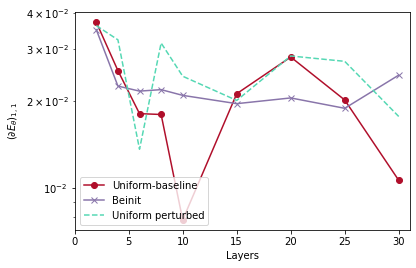

In [35]:

plt.semilogy(layers, gv_unif_bline_lavg, '-o', c='#b00f2b', label='Uniform-baseline')
# plt.semilogy(layers, gv_unif_bline_lavg, '-o', label='Uniform-baseline')
plt.semilogy(layers, gv_beinit_lavg, '-x', c='#8975aa', label='Beinit')
plt.semilogy(layers, gv_unif_pert_lavg, '--', c='#55d8b4', label='Uniform perturbed')
# plt.semilogy(layers, gv_unif_pert_lavg, '-^', c='#55d8b4', label='Uniform-pert')
# plt.semilogy(layers, np.exp(pu[0]*np.array(layers, dtype='float') + pu[1]), '-x',
#              c='#b00f2b', alpha=0.75,
#              label=f"Uniform slope: {pu[0]:3.2f}")
plt.xlabel("Layers")
plt.ylabel(r"($\partial E_{\theta})_{1, 1}$")
plt.legend()
plt.xlim(0, 31)
plt.savefig('iris_layer_expt_new.png', dpi=300, bbox_inches='tight')
# plt.ylim(1e-2, 1e-1)